In [8]:
import os
import zipfile
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display

# **Downloading the data**

There are 123 images of dogs
There are 123 images of cats
There are 116 images of birds


Sample cat image:


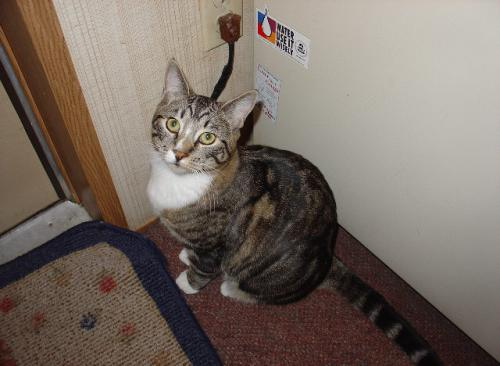


Sample dog image:


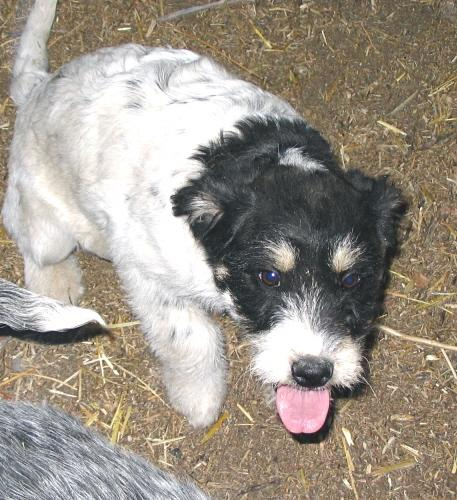


Sample bird image:


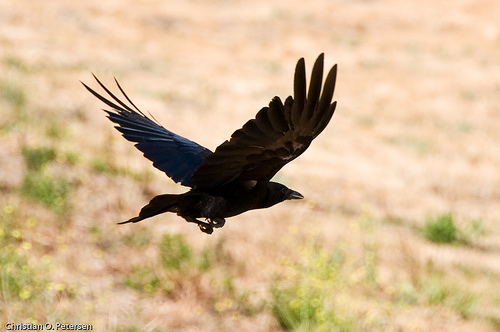

In [9]:
# Download the images
# Set a base directory
base_dir = 'images'

# Unzip images
with zipfile.ZipFile('images.zip', 'r') as my_zip:
  my_zip.extractall(base_dir)

# Save paths for images of each class
dogs_dir = os.path.join(base_dir, 'images/dogs')
cats_dir = os.path.join(base_dir,'images/cats')
birds_dir = os.path.join(base_dir,'images/birds')

# Print number of images for each class
print(f"There are {len(os.listdir(dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(cats_dir))} images of cats")
print(f"There are {len(os.listdir(birds_dir))} images of birds\n\n")

# Look at sample images of each class
print("Sample cat image:")
display(Image(filename=f"{os.path.join(cats_dir, os.listdir(cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(dogs_dir, os.listdir(dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(birds_dir, os.listdir(birds_dir)[0])}"))

# **Load a pretrained model**


In [10]:
model = tf.keras.models.load_model('content/model')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

# **Save the model**


To load the pretrained model to tensor serving we need to save it in a SavedModel.

In [12]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = 'Savedmodel'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')


# Save the model
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = Savedmodel\1

INFO:tensorflow:Assets written to: Savedmodel\1\assets


INFO:tensorflow:Assets written to: Savedmodel\1\assets


# Prepare data for inference

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the directory with the test images
val_gen_no_shuffle = test_datagen.flow_from_directory(
    'images/images',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

# Print the label that is assigned to each class
print(f"labels for each class in the test generator are: {val_gen_no_shuffle.class_indices}")

Found 362 images belonging to 3 classes.
labels for each class in the test generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [15]:
# Get a batch of 32 images along with their true label
data_imgs, labels = next(val_gen_no_shuffle)

# Check shapes
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


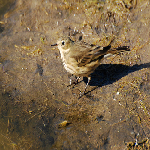

Image shows a bird.



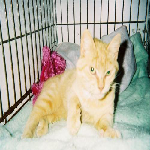

Image shows a cat.



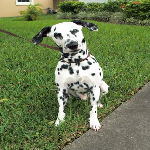

Image shows a dog.



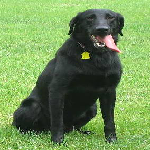

Image shows a dog.



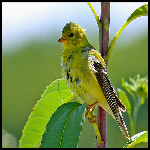

Image shows a bird.



In [16]:
from tensorflow.keras.preprocessing.image import array_to_img

# Returns string representation of each class
def get_class(index):
  if index == 0:
    return "bird"
  elif index == 1:
    return "cat"
  elif index == 2:
    return "dog"
  return None


# Plots a numpy array representing an image
def plot_array(array, label, pred=None):
  array = np.squeeze(array)
  img = array_to_img(array)
  display(img)
  if pred is None:
    print(f"Image shows a {get_class(label)}.\n")
  else:
    print(f"Image shows a {get_class(label)}. Model predicted it was {get_class(pred)}.\n")


# Plot the first 5 images in the batch
for i in range(5):
  plot_array(data_imgs[i], labels[i])

# Serve your model with TensorFlow Serving

First install tensorfow based in your system. I am using Windows so I used a docker image.
Then Proceed to the following steps to start the server.

In [32]:
import os
import subprocess
import time

# Set the path to your model directory
MODEL_DIR = "Savedmodel\1"
os.environ["MODEL_DIR"] = MODEL_DIR

# Start TensorFlow Serving
command = f"nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=animal_classifier \
  --model_base_path={MODEL_DIR} > server.log 2>&1 &"

subprocess.Popen(command, shell=True)


<Popen: returncode: None args: 'nohup tensorflow_model_server   --rest_api_p...>

# Make REST requests

In [34]:
import json

# Convert numpy array to list
data_imgs_list = data_imgs.tolist()

# Create JSON to use in the request
data = json.dumps({"instances": data_imgs_list})

In [35]:
import requests

# Define headers with content-type set to json
headers = {"content-type": "application/json"}

# Capture the response by making a request to the appropiate URL with the appropiate parameters
json_response = requests.post('http://localhost:8501/v1/models/animal_classifier:predict', data=data, headers=headers)

# Parse the predictions out of the response
predictions = json.loads(json_response.text)['predictions']

# Print shape of predictions
print(f"predictions has shape: {np.asarray(predictions).shape}")

predictions has shape: (32, 3)


In [36]:
# Compute argmax
preds = np.argmax(predictions, axis=1)

# Print shape of predictions
print(f"preds has shape: {preds.shape}")

preds has shape: (32,)


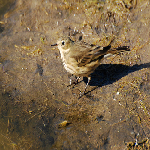

Image shows a bird. Model predicted it was bird.



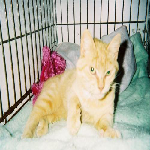

Image shows a cat. Model predicted it was dog.



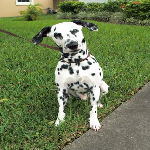

Image shows a dog. Model predicted it was bird.



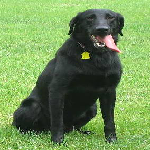

Image shows a dog. Model predicted it was dog.



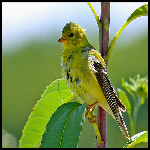

Image shows a bird. Model predicted it was bird.



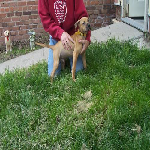

Image shows a dog. Model predicted it was dog.



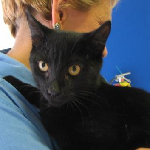

Image shows a cat. Model predicted it was cat.



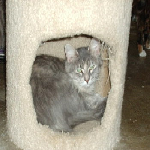

Image shows a cat. Model predicted it was cat.



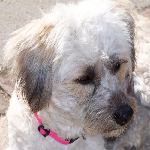

Image shows a dog. Model predicted it was cat.



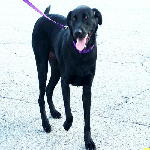

Image shows a dog. Model predicted it was dog.



In [37]:
for i in range(10):
  plot_array(data_imgs[i], labels[i], preds[i])